In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

this_state = 'MO'
this_state_number = 29   # could get this from extras data, but meh, just look it up each time

# from shapely.ops import unary_union
# from matplotlib import pyplot as plt
# import matplotlib.patches as mpatches
# import re
# from pprint import pprint

thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'

output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())

#acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
#extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

# water_area_tol = 1 * 1000 * 1000
# overlap_area_tract_tol = 22000
# overlap_area_bg_tol = 4000
# #smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
# #smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

#scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime']

debug = 1
g = 0

print('ok')

ok


In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('\tFixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())
print('\n')

if (debug >= 1):
    print('reading roads shapefiles in {0:}...'.format(this_state))

roads_gdf = geopandas.GeoDataFrame()
roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

for i in range(0, len(roads_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
    roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
    roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

roads_gdf = roads_gdf.set_index('LINEARID')

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

e = time.time()
g = g + (e-s)

if (debug >= 1):
    print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

print('ok')

reading congressional districts with urban/rural area data...
	Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.0 seconds.


reading roads shapefiles in MO...
	Reading file 1 of 115...
	Reading file 11 of 115...
	Reading file 21 of 115...
	Reading file 31 of 115...
	Reading file 41 of 115...
	Reading file 51 of 115...
	Reading file 61 of 115...
	Reading file 71 of 115...
	Reading file 81 of 115...
	Reading file 91 of 115...
	Reading file 101 of 115...
	Reading file 111 of 115...
	Reading file 115 of 115...
Read 640,641 roads in 123.5 seconds!
ok


In [3]:
def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 
print('ok')

ok


In [6]:
s = time.time()

nDistricts = cd_gdf[cd_gdf['STATEFP'] == this_state_number]['CD116FP'].max()

manual_plot_limits = False

metrobox_xlim = (-91,-90)
metrobox_ylim = (38,39)

print('defining metrobox...')
metrobox_geo = makebox(metrobox_xlim, metrobox_ylim)

print('Finding roads in metrobox...')
print('\tsetting series...')
is_in_metrobox_s = roads_gdf[
    (roads_gdf.geometry.apply(lambda x: x.boundary.is_empty == False))
].geometry.apply(lambda x: (x.boundary[0].within(metrobox_geo)) | (x.boundary[1].within(metrobox_geo)))

print('\tgetting indices...')
roads_in_metrobox_ix = is_in_metrobox_s[is_in_metrobox_s == True].index.tolist()
roads_not_in_metrobox_ix = is_in_metrobox_s[is_in_metrobox_s == False].index.tolist()

print('creating gdf of roads by road type and in vs out...')
print('\tbig roads...')
big_roads_in_metro_gdf = roads_gdf[(roads_gdf.index.isin(roads_in_metrobox_ix)) & (roads_gdf['RTTYP'].isin(['I', 'U', 'S', 'C']))]
big_roads_not_in_metro_gdf = roads_gdf[~((roads_gdf.index.isin(roads_not_in_metrobox_ix)) | (roads_gdf['RTTYP'].isin(['I', 'U', 'S', 'C'])))]

print('\tsmall roads...')
small_roads_in_metro_gdf = roads_gdf[(roads_gdf.index.isin(roads_in_metrobox_ix)) & (roads_gdf['RTTYP'].isin(['M', 'O']))]
small_roads_not_in_metro_gdf = roads_gdf[~((roads_gdf.index.isin(roads_not_in_metrobox_ix)) | (roads_gdf['RTTYP'].isin(['M','O'])))]

print('\tunnamed roads...')
untyped_roads_in_metro_gdf = roads_gdf[(roads_gdf.index.isin(roads_in_metrobox_ix)) & (roads_gdf['RTTYP'].isnull())]
untyped_roads_not_in_metro_gdf = roads_gdf[~((roads_gdf.index.isin(roads_not_in_metrobox_ix)) | (roads_gdf['RTTYP'].isnull()))]


e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


defining metrobox...
Finding roads in metrobox...
	setting series...
	getting indices...
creating gdf of roads by road type and in vs out...
	big roads...
	small roads...
	unnamed roads...
Done in 1 minutes 55 seconds!


Plotting official districts...


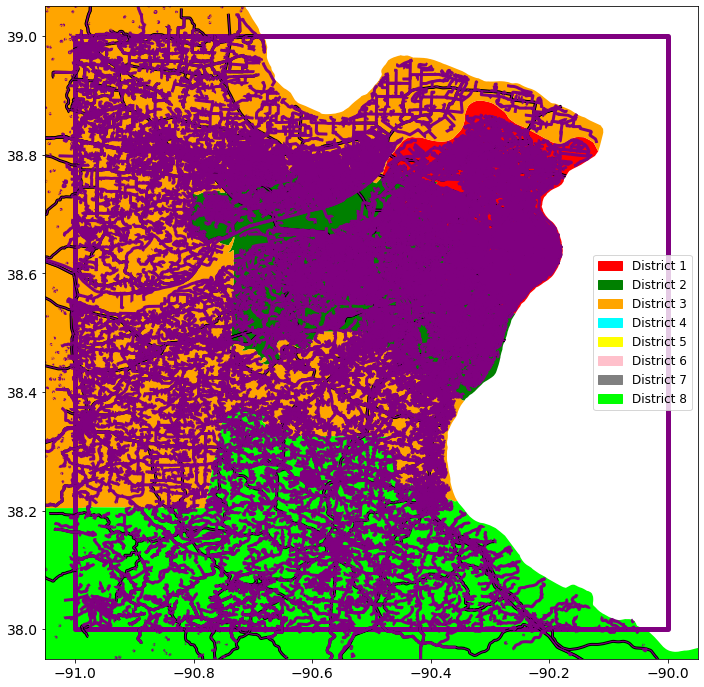

Done in 0 minutes 58 seconds!


In [7]:
s = time.time()
manual_plot_limits  = True

manual_xlim  = metrobox_xlim
manual_ylim = metrobox_ylim

legend_location = 'center right'

map_buffer_ratio = .05

fig, ax = plt.subplots(1,1,figsize=(12,12))

print('Plotting official districts...')

legend_list = []

for i in range(1, nDistricts+1):
    cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
    legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


if (manual_plot_limits):
    xlimits = (manual_xlim[0], manual_xlim[1])
    ylimits = (manual_ylim[0], manual_ylim[1])
    xspan = xlimits[1] - xlimits[0]
    yspan = ylimits[1] - ylimits[0]
    xbuffer = xspan * map_buffer_ratio
    ybuffer = yspan * map_buffer_ratio
    ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
    ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


metrobox_gdf = geopandas.GeoDataFrame(data=[[metrobox_geo]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')

metrobox_gdf.plot(ax=ax, color='None', edgecolor='purple', lw=5)



# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax, color='gray', lw=0.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', lw=1)
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', lw=2)
#roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', lw=3)

# roads_gdf[
#     (roads_gdf['RTTYP'] == 'I') 
#     & (roads_gdf.geometry.apply(lambda x: x.intersects(metrobox_geo) == True))
# ].plot(ax=ax, color='black', lw=3)

big_roads_in_metro_gdf.plot(ax=ax, color='black', lw=3) 
small_roads_in_metro_gdf.plot(ax=ax, color='black', lw=1) 
untyped_roads_in_metro_gdf.plot(ax=ax, color='black', lw=0.25) 



big_roads_not_in_metro_gdf.plot(ax=ax, color='purple', lw=3) 
small_roads_not_in_metro_gdf.plot(ax=ax, color='purple', lw=1) 
untyped_roads_not_in_metro_gdf.plot(ax=ax, color='purple', lw=0.25) 



#roads_gdf.loc[roads_in_metrobox_ix].plot(ax=ax, color='black', lw=3)
#roads_gdf.loc[roads_not_in_metrobox_ix].plot(ax=ax, color='red', lw=3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))




saving files...
	big roads...
	small roads...
	untyped roads...
In Metrobox: saved 758 big and 51,405 small and 30,636 untyped roads!
Not in Metrobox: saved 102,549 big and 49,277 small and 55,070 untyped roads!
Done in 1 minutes 45 seconds!
testing...


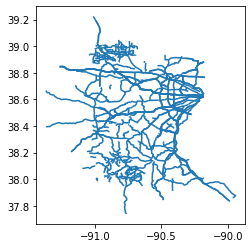

In [8]:
s = time.time()
print('saving files...')

print('\tbig roads...')
big_roads_in_metro_gdf.to_file(output_dir+'roads_big_metro.shp') 
big_roads_not_in_metro_gdf.to_file(output_dir+'roads_big_not_metro.shp') 

print('\tsmall roads...')
small_roads_in_metro_gdf.to_file(output_dir+'roads_small_metro.shp') 
small_roads_not_in_metro_gdf.to_file(output_dir+'roads_small_not_metro.shp') 

print('\tuntyped roads...')
untyped_roads_in_metro_gdf.to_file(output_dir+'roads_untyped_metro.shp') 
untyped_roads_not_in_metro_gdf.to_file(output_dir+'roads_untyped_not_metro.shp') 

# print('\tunnamed roads...')
# untyped_roads_in_metro_gdf #= roads_gdf[(roads_gdf.index.isin(roads_in_metrobox_ix)) & (roads_gdf['RTTYP'].isnull())]
# untyped_roads_not_in_metro_gdf# = roads_gdf[(roads_gdf.index.isin(roads_not_in_metrobox_ix)) & (roads_gdf['RTTYP'].isnull())]

print('In Metrobox: saved {0:,.0f} big and {1:,.0f} small and {2:,.0f} untyped roads!'.format(len(big_roads_in_metro_gdf), len(small_roads_in_metro_gdf), len(untyped_roads_in_metro_gdf)))
print('Not in Metrobox: saved {0:,.0f} big and {1:,.0f} small and {2:,.0f} untyped roads!'.format(len(big_roads_not_in_metro_gdf), len(small_roads_not_in_metro_gdf), len(untyped_roads_not_in_metro_gdf)))

e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

print('testing...')
q = geopandas.read_file(output_dir+'roads_big_metro.shp')
q.plot()

In [ ]:
# # roads_gdf.sample(2)
# # print(roads_gdf.groupby('RTTYP').size())
# # print('None: {0:.0f}'.format(len(roads_gdf[roads_gdf['RTTYP'].isnull()])))

# #roads_gdf[roads_gdf['RTTYP'].isin(['I','U', 'S', 'C'])]
# #roads_gdf

# print('saving big roads...')
# roads_gdf[roads_gdf['RTTYP'].isin(['I','U', 'S', 'C'])].to_file(output_dir + 'big_roads.shp')
# print('saving small roads...')
# roads_gdf[roads_gdf['RTTYP'].isin(['M','O'])].to_file(output_dir + 'small_roads.shp')
# print('saving unnamed roads...')
# roads_gdf[roads_gdf['RTTYP'].isnull()].to_file(output_dir + 'unnamed_roads.shp')


# print('ok')


In [ ]:
# u = geopandas.read_file(output_dir + 'unnamed_roads.shp')
# u.plot()